# Colorado covid projections using realtime update of $R_0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import emcee
import pandas as pd
from scipy import integrate
import pymc3 as pm

In [2]:
# i like my ticks big
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13

In [3]:
us_confirmed = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [4]:
def raw_data(state):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:] # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:] # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    return df

def smooth_data(state,window = 7):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:].diff()  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:].diff()  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    df = df.rolling(window=window).mean() # rolling mean window to smoothen out data
    df = df[window:].round()
    df = df.clip(lower = 1)
    return df

In [5]:
colorado = smooth_data('Colorado',window=7) # smoothened data with mean filter of 7 day
raw = raw_data('Colorado') # raw daily case and death counts 

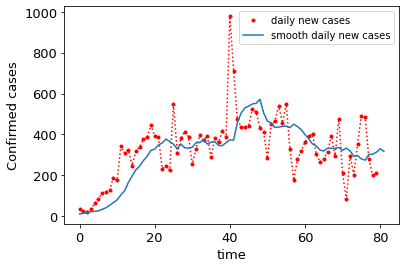

In [6]:
plt.plot(np.diff(raw.confirmed.values)[9:], 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.diff(raw.confirmed.values)[9:], 'r:')
plt.plot(np.arange(len(colorado)),colorado.confirmed,label = 'smooth daily new cases')
plt.xlabel('time',fontsize = 13)
plt.ylabel('Confirmed cases',fontsize = 13)
plt.legend()
plt.savefig('images/daily_cases.pdf')

plt.show()

In [7]:
raw.deaths

3/5/20        0
3/6/20        0
3/7/20        0
3/8/20        0
3/9/20        0
           ... 
5/29/20    1436
5/30/20    1443
5/31/20    1445
6/1/20     1458
6/2/20     1474
Name: deaths, Length: 90, dtype: object

The raw number of new daily cases is highly noisey and likely doesn't represent the true spread of the pandemic. In order to reduce the noise in our predictions, we smooth the number of daily cases by rolling mean window of 7 days. 

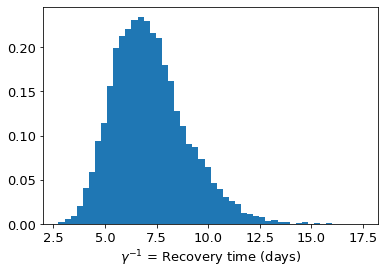

In [8]:
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282-f1
s, loc, scale = 0.25,0,7
gamma = stats.lognorm.rvs(s,loc,scale,size=10000)
gamma = 1/gamma
plt.hist(1/gamma,bins=50,density=True)
plt.xlabel('$\gamma^{-1}$ = Recovery time (days)',fontsize = 13)
plt.savefig('images/recovery_time.pdf')
plt.show()

$\gamma$ is not a single number, rather it's a random variable. In the SIR model, $\gamma^{-1}$ equals the recovery time for an infected patient. According the CDC, recovery times have been observed to have the [following distribution](https://wwwnc.cdc.gov/eid/article/26/7/20-0282-f1). In this work, we model it with a log-normal distribution with the parameters above. The resulting distribution for recovery times is shown above. From this we calculate:

$\gamma = $ recovery time $^{-1}$ 

In [9]:
# draw gamma from the appropriate log-normal distribution
def draw_gamma():
    s, loc, scale = 0.25,0,7
    gamma = stats.lognorm.rvs(s,loc,scale)
    return 1/gamma
    

In [10]:
r0_grid = np.linspace(0,5,num=1000)

In [11]:
def newcases(yesterday_cases,gamma,R):
    out = yesterday_cases
    out *= np.e**(gamma*(R-1))
    return out


In [12]:
# compute likelihood -> poisson
def r0_lhood(r0,gamma,yest_nc,today_nc,tol = 1e-6):
    prediction = newcases(yest_nc,gamma,r0)
    lhood = stats.poisson.logpmf(today_nc,prediction + tol)
    return lhood

The ```newcases``` function provides a relationship between today's new cases as a function of yesterday's cases, effective R0 and $\gamma$. This equation comes form [Bettencourt, Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185). It states:

$\text{new cases}_{t+1} = \text{new cases}_{t} \text{ }e^{\gamma (R_0 - 1)}$

Where $R_0$ represnts an 'effective spread rate' whose value can change with time (due to changes in behaviour, social distancing, herd immunity, etc.)

Given this model for the number of cases on a given day, we can compute the liklelihood for observing a given number of cases according the poisson distribution. 

Now we can start our bayesian update in which $R_0$ is continously updated as we get more data. First, we compute the likelihood. This is the probablity of observing a number of cases on a given day depending on $R_0$. 

Then there is the prior which refelcts our prior beliefs about $R_0$. On the first day, we use a flat prior. After that, the likelihood for the previous day becomes the prior for the next day. Additionaly, we add a bit of randomness to the prior by widening the prior out by a gaussian. This seems to give better results since the randomness ensures prior information is slowly forgotten after a number of days.

In [13]:
def bayes_update(confirmed_vals,gamma,sigma=0.2):
    # Compute likelihoods
    likehoods = []
    for i in range(len(confirmed_vals)-1):
        yesterday = confirmed_vals[i]
        today = confirmed_vals[i+1]
        pmf = np.e**r0_lhood(r0_grid,gamma,yesterday,today)
        pmf /= np.sum(pmf)
        likehoods.append(pmf)
    likehoods = np.array(likehoods)
    
    
    # Process matrix add random perturbations the priors

    process_matrix = stats.norm(loc=r0_grid,scale=sigma).pdf(r0_grid[:, None]) 

   
    posteriors = []
    prior = np.ones(len(r0_grid))/len(r0_grid)

    for i in range(len(confirmed_vals) - 1):
        posterior = likehoods[i] * prior
        posterior /= np.sum(posterior)
        posteriors.append(posterior)   
        prior = process_matrix @ posterior

    posteriors = np.array(posteriors)
    
    return likehoods,posteriors

Draw a random value of $\gamma$ and compute effective $R_0$ posteriors for each day. The posterior on any given day is the sum of the individual posteriors for each value of $\gamma$...

In [14]:
likehoods = np.zeros((len(colorado) - 1,len(r0_grid)))
posteriors = np.zeros((len(colorado) - 1,len(r0_grid)))

draws = 1000
for _ in range(draws):
    g = draw_gamma()
    l, p = bayes_update(colorado.confirmed.values,g)
    likehoods += l
    posteriors += p

# Finally normlize again
likehoods/= draws
posteriors/= draws

Let's see what our posteriors and likelihoods look like on various days:

In [15]:
colorado.index

Index(['3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20',
       '4/13/20', '4/14/20', '4/15/20', '4/16/20', '4/17/20', '4/18/20',
       '4/19/20', '4/20/20', '4/21/20', '4/22/20', '4/23/20', '4/24/20',
       '4/25/20', '4/26/20', '4/27/20', '4/28/20', '4/29/20', '4/30/20',
       '5/1/20', '5/2/20', '5/3/20', '5/4/20', '5/5/20', '5/6/20', '5/7/20',
       '5/8/20', '5/9/20', '5/10/20', '5/11/20', '5/12/20', '5/13/20',
       '5/14/20', '5/15/20', '5/16/20', '5/17/20', '5/18/20', '5/19/20',
       '5/20/20', '5/21/20', '5/22/20', '5/23/20', '5/24/20', '5/25/20',
       '5/26/20', '5/27/20', '5/28/20', '5/29/20', '5/30/20', '5/31/20',
       '6/1/20', '6/2/20'],
      dtype='object

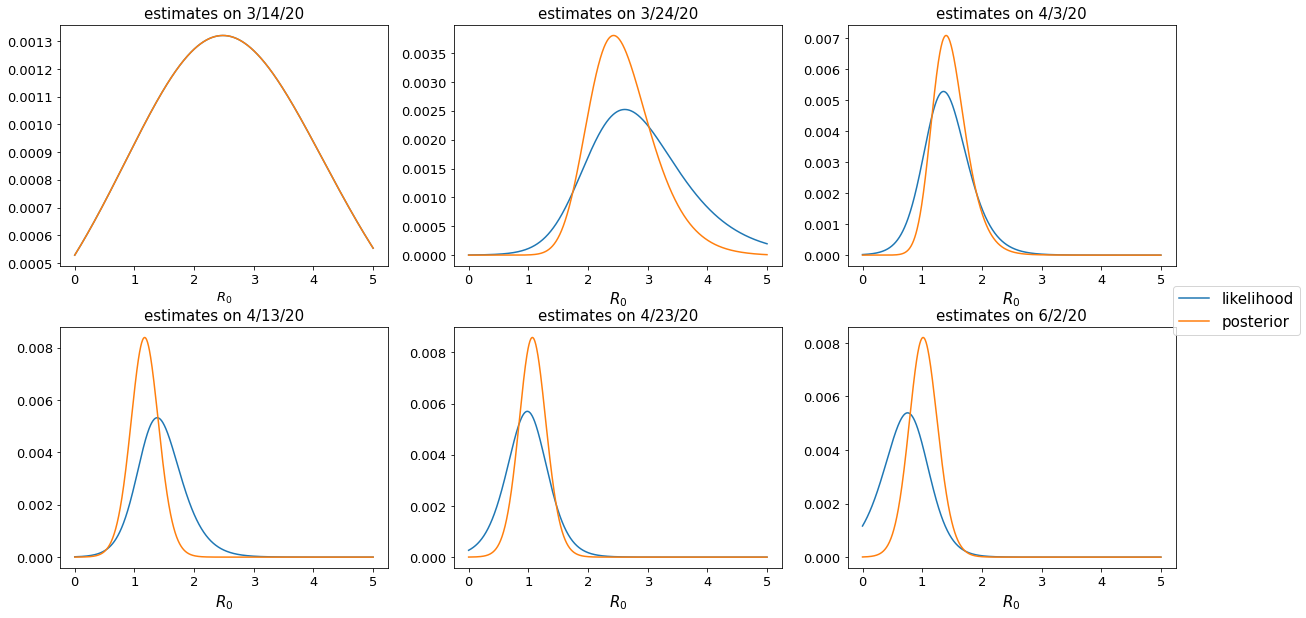

In [16]:
figure = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.25)
plt.subplot(231)
i = 0
plt.title('estimates on '+ colorado.index[i+1],fontsize = 15)
plt.plot(r0_grid,likehoods[i],label = 'likelihood')
plt.plot(r0_grid,posteriors[i],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 13)

plt.subplot(232)
i = 10
plt.title('estimates on '+ colorado.index[i+1],fontsize = 15)
plt.plot(r0_grid,likehoods[i],label = 'likelihood')
plt.plot(r0_grid,posteriors[i],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 15)

plt.subplot(233)
i = 20
plt.title('estimates on '+ colorado.index[i+1],fontsize = 15)
plt.plot(r0_grid,likehoods[i],label = 'likelihood')
plt.plot(r0_grid,posteriors[i],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 15)

plt.subplot(234)
i = 30
plt.title('estimates on '+ colorado.index[i+1],fontsize = 15)
plt.plot(r0_grid,likehoods[i],label = 'likelihood')
plt.plot(r0_grid,posteriors[i],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 15)

plt.subplot(235)
i = 40
plt.title('estimates on '+ colorado.index[i+1],fontsize = 15)
plt.plot(r0_grid,likehoods[i],label = 'likelihood')
plt.plot(r0_grid,posteriors[i],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 15)

plt.subplot(236)
plt.title('estimates on '+ colorado.index[-1],fontsize = 15)
plt.plot(r0_grid,likehoods[-1],label = 'likelihood')
plt.plot(r0_grid,posteriors[-1],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 15)
plt.legend(bbox_to_anchor=(1.4,1.2),fontsize = 15)
plt.savefig('images/posteriors.pdf')
plt.show()


Initialy we dont really know much about our value of $R_0$ and hence our posterior is quite broad. As we get more data, both the likelihoods and posteriors start to narrow. As time progresses, $R_0$'s tend to decrease as we continue our efforts at 'flattening the curve'. 

It's also worth noting that the likelihood for any given day is rather volatile since it depends only on the daily case counts. Whereas the posterior for the day is less volatile since it's priors are informed by the previous days posteriors

In [17]:
from scipy.signal import argrelextrema

We can summarize our posteriors by the mean and HPD

In [18]:
def mean(dist_array):
    mu = np.sum(dist_array * r0_grid)/np.sum(dist_array)    
    return mu

# Binary search to calculate 95% HPD
def hpd(dist_array,interval = 0.95,iterations=50):
    y_up = np.max(dist_array) 
    y_lo = np.mean(dist_array)

    for i in range(iterations):
        y_m = (y_lo + y_up)*0.5
        x_loc = argrelextrema(np.abs(dist_array - y_m),np.less)[0]
        
        # edge case where minimum at 0 cant be found
        if len(x_loc) == 1:
            x_loc = np.append(0,x_loc)
            
        y_vals = dist_array[x_loc[0]:x_loc[1]]
        mass = np.sum(y_vals)

        if mass < interval:
            y_up = y_m
        elif mass > interval:
            y_lo = y_m
    
    return r0_grid[x_loc]
    

In [19]:
mu_list = np.zeros(len(posteriors))
hpd_list = np.zeros((len(posteriors),2))

for i in range(len(posteriors)):
    mu_list[i] = mean(posteriors[i])
    hpd_list[i] = hpd(posteriors[i])
    

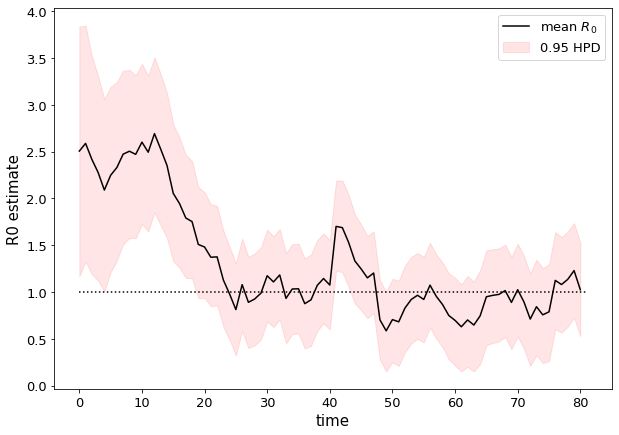

In [20]:
plt.figure(figsize=(10,7))
plt.plot(mu_list,'black',label = 'mean $R_0$')

lo = hpd_list.transpose()[0]
up = hpd_list.transpose()[1]

plt.fill_between(np.arange(len(mu_list)),
                 up,lo, 
                 color = 'red', alpha = 0.1 ,label = '0.95 HPD')

plt.hlines(1,0,len(posteriors),linestyle = ':')
plt.xlabel('time',fontsize =15)
plt.ylabel('R0 estimate',fontsize =15)
plt.legend(fontsize = 13)
plt.savefig('images/r0time.pdf')
plt.show()


We need to be able to draw a value of $R_0$ from it's posterior distribution

In [21]:
# draw R0 from the current posterior using the inverse CDF method

def draw_r0(posterior,size = 1):
    cdf = np.cumsum(posterior)
    cdf /= cdf[-1]
    
    samples = np.zeros(size)
    for i in range(size):
        u = np.random.rand()

        loc = np.argmin(np.abs(cdf - u))
        samples[i] = r0_grid[loc]
        
        
    if size == 1: 
        return samples[0]
    else:
        return samples
    

Let's look at the posterior from the lastest day and draw from it by the inverse CDF method.

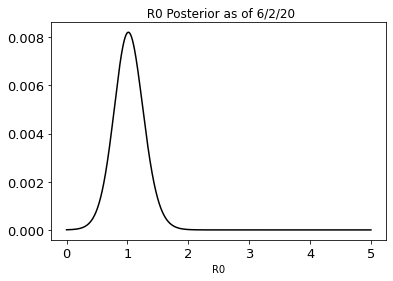

In [22]:
plt.plot(r0_grid,posteriors[-1],color = 'black')
plt.xlabel('R0')
plt.title(' R0 Posterior as of ' + colorado.index[-1])
plt.show()


Text(0.5, 0, 'R0')

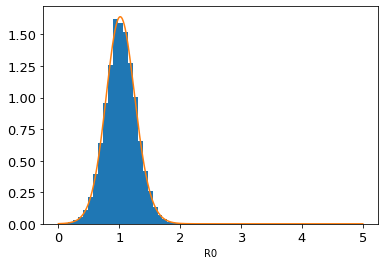

In [23]:
plt.hist(draw_r0(posteriors[-1],size=100000),bins=30,density=True)
plt.plot(r0_grid,posteriors[-1]*200)
plt.xlabel('R0')

Great, it works!

### Testing method validity

To test the validity of this method, we can make a prediction for day $n$. But we're only allowed to use the confirmed cases for the previous $n-1$ days. 

For example if we want to predict the number of cases on the 10th day, we're only allowed to look at the data for the previous 9 days. Let's predict the number of cases for each day and see how well our prediction for that day lines up with the true cases. This way, we can test how accurate this model is.

In [24]:
def predict_cases(day,ndraws = 100):
    
    assert day >= 2, 'day >= 2'
    
    yesterday_post = posteriors[day - 2]
    yesterday_cases = colorado.confirmed[day - 1]
    all_preds = []
    
    for _ in range(ndraws):
        r = draw_r0(yesterday_post)
        g = draw_gamma()
        pred = newcases(yesterday_cases,g,r)
        pred = stats.poisson.rvs(pred) # remember to add poisson noise
        all_preds.append(pred)
        
    all_preds = np.array(all_preds)

    return np.mean(all_preds),pm.hpd(all_preds,credible_interval=0.95)

In [25]:
days = np.arange(len(colorado))[2:]
all_predicts = []
for i in days:
    all_predicts.append(predict_cases(i))

In [26]:
all_predicts[1:6]

[(23.18, array([10, 33])),
 (26.49, array([16, 39])),
 (28.58, array([17, 40])),
 (31.6, array([17, 45])),
 (39.75, array([26, 58]))]

In [27]:
percent_diff = []
for i in range(len(all_predicts)):    
    err = colorado.confirmed.values[i+2] - all_predicts[i][0]
    err /= colorado.confirmed.values[i+2]
    percent_diff.append(np.abs(err))
print('mean error =', np.mean(percent_diff)*100, '%')

mean error = 4.6490246045693615 %


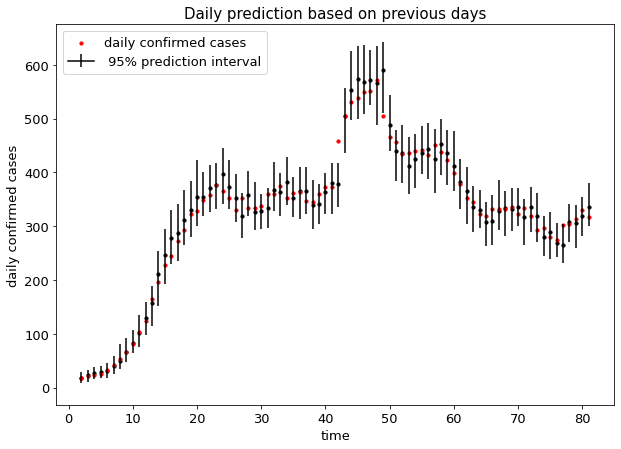

In [28]:
# Now plot predictions:
plt.figure(figsize=(10,7))
for i in days:
    pred = all_predicts[i - 2]
    plt.scatter(i,pred[0],color = 'black',s = 10)
    bars_hpd = np.abs((pred[1] - pred[0])[:,None])
    plt.errorbar(i,pred[0],bars_hpd,color = 'black')
    plt.scatter(i,colorado.confirmed.values[i],color = 'red',s = 10)

plt.xlabel('time',fontsize = 13)
plt.ylabel('daily confirmed cases',fontsize = 13)
plt.errorbar(i,0,0,color = 'black',label = ' 95% prediction interval')
plt.scatter(2,colorado.confirmed.values[2],color = 'red',s = 10,label = 'daily confirmed cases')

plt.legend(loc='upper left',fontsize = 13)
plt.title('Daily prediction based on previous days',fontsize = 15)
plt.savefig('images/validation.pdf')
plt.show()

Our predictions match the data reasonably well! When the number of observed cases changes abruptly, our predictions tend to be slightly innacurate. We see an example of this happening around day 40 (25th April). Around this time, the number of daily cases dropped rapidly. But our model overpredicted the number of cases since it's priors were informed by the precceding days in which the number of cases was increasing. 

These results would also likely depend on the window size in my initial smoothing of the data. However, based on this plot, my model can be trusted to make rough predictions regarding the spread of covid in the near future. 

Using these estimates, we can project into the future. There are 2 forms of noise to consider here:
1. Noise due to uncertainty about $R_0$ and $\gamma$
2. Inherent noise due to the poission statistics for cases on any given day

We take both these into account in our extrapolations...

In [29]:
def extrapolate(r,g,days=20):
    proj = [colorado.confirmed[-1]]
    for i in range(days):
        tomorrow = newcases(proj[-1],g,r) # model prediction
        tomorrow = stats.poisson.rvs(tomorrow) # including poisson noise
        proj.append(tomorrow)
    return np.array(proj)
    

In [30]:
def plot_projections(preds,**kwargs):
    time = np.arange(len(colorado.confirmed))
    plt.plot(time, colorado.confirmed,'ro',markersize = 3)
    plt.plot(time, colorado.confirmed,'r:')

    
    future_time = np.arange(len(time) -1 ,len(time) + len(preds) -1)
    plt.plot(future_time,preds,**kwargs)

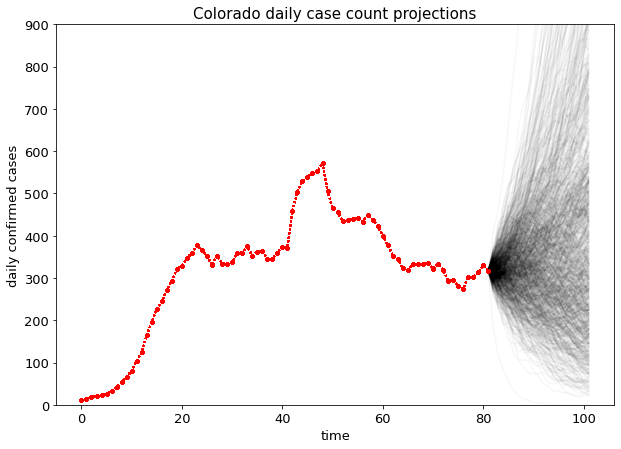

In [31]:
plt.figure(figsize=(10,7))
for _ in range(1000):
    r0 = draw_r0(posteriors[-1])
    g = draw_gamma()
    plot_projections(extrapolate(r0,g),alpha = 0.03,color = 'black')
    plt.ylim(0,900)
plt.ylabel('daily confirmed cases',fontsize = 13)
plt.xlabel('time',fontsize = 13)
plt.title('Colorado daily case count projections',fontsize = 15)
plt.savefig('images/predict_cases.pdf')
plt.show()



Currently the effective posterior has most of its mass below $R_0 = 1$. Hence we expect the pandemic to die out. Most of these curves are decaying with time. But there are a few that increase since there's still a non-zero chance that $R_0 > 1$

Using our estimate of the number of confirmed cases, we can also estimate the number of deaths...
The case fatality rate is defined as:

$CFR = \frac{\text{deaths}}{\text{confirmed cases}}$ 


We have data on both the numerator and the deniminator. However, these numbers are not 'exact'. Deaths and case count's are random variables and likley follow a poission distribution. We can model this to get a distribution for the CFR

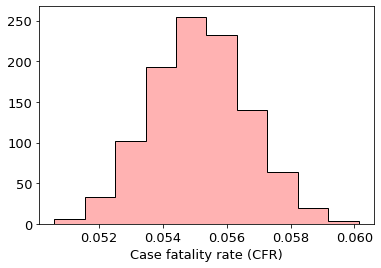

In [32]:
raw = raw_data('Colorado')
cfr = np.random.poisson(raw.deaths[-1],size = 1000)/np.random.poisson(raw.confirmed[-1],size = 1000)
plt.hist(cfr,color = 'red',alpha = 0.3,density=True)
plt.hist(cfr,color = 'black',histtype = 'step',density=True)
plt.xlabel('Case fatality rate (CFR)',fontsize = 13)
plt.savefig('images/cfr.pdf')
plt.show()

Colorado's CFR is somewhere around 5%...

In [33]:
def death_project(r,g,days = 20):
    cfr = np.random.poisson(raw.deaths[-1])/np.random.poisson(raw.confirmed[-1])
    
    future_cases = extrapolate(r,g,days=20)[1:]
    future_deaths = np.cumsum(future_cases) * cfr 
    future_deaths += raw.deaths[-1]  # add in current death toll
    future_deaths = stats.poisson.rvs(future_deaths)
    
    deaths = np.append(raw.deaths.values,future_deaths)

    return deaths
    

Using this case fatality rate we can project the number of deaths into the future.

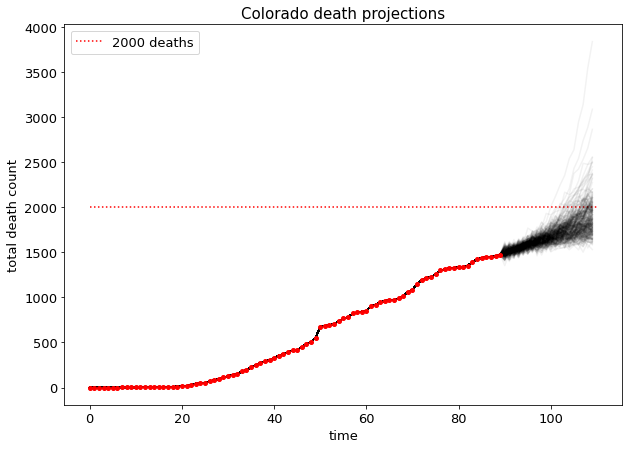

In [49]:
hline = 2000

plt.figure(figsize=(10,7))
for i in range(300):
    r = draw_r0(posteriors[-1])
    g = draw_gamma()
    plt.plot(death_project(r,g),alpha = 0.05,color = 'black')
plt.plot(raw.deaths.values,'ro',markersize = 4)
plt.xlabel('time',fontsize = 13)
plt.ylabel('total death count',fontsize = 13)
plt.title('Colorado death projections',fontsize = 15)
plt.hlines(hline,0,len(raw)+20,linestyle=':',color = 'red' , label = str(hline)+' deaths')
plt.legend(fontsize = 13)
plt.savefig('images/predict_deaths.pdf')
plt.show()

In [36]:
## TODO:

# Estimate gamma from https://wwwnc.cdc.gov/eid/article/26/7/20-0282-f1
# Is the idea of a process matrix good? Seems like this depends quite significantly on the smoothing
# Play around with the smoothing